In [21]:
using MIRTjim
using Plots
using FFTW
using Random
using LinearAlgebra
using MAT

include("utils.jl");

In [22]:
# read in data from mat file
kdata = matread("./data/2D_T1_data.mat")["kData"];

# get sizes
nd = ndims(kdata) - 1; # number of image dimensions
N = size(kdata)[1:nd]; # image size
Q = size(kdata, nd + 1); # number of channels

In [23]:
# set PISCO parameters
τ = Int(3); # neighborhood size (radius)
N_cal = 32; # size of calibration region
σ_thresh = 0.002; # threshold for singular values
d_sk = 50; # sketch dimension for SVD of ChC (overestimation of the rank)

# set PISCO techniques
kernel_shape = 1; # (0 for rect, 1 for circle)
fft_conv_mtx = 0; # option to approximate ChC with FFTs

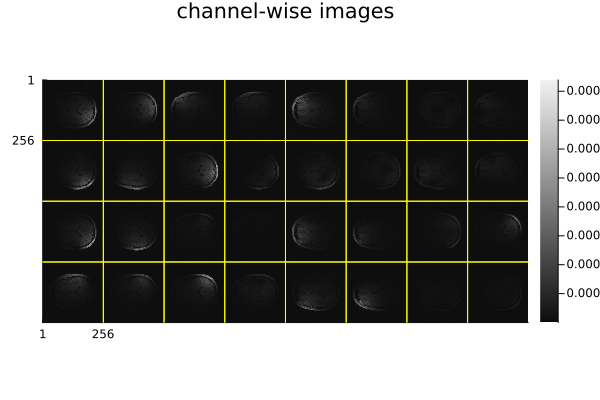

In [24]:
# get aliased image
idata = fftshift(ifft(ifftshift(kdata,1:nd),1:nd),1:nd);
jim(idata, title="channel-wise images")

In [25]:
# extract calibration data from kcal
cal_subs = [ceil.(Int,N[d]/2) + even_RL(N[d]/2) .+
    (-floor(Int,N_cal/2):floor(Int,N_cal/2)-even_RL(N_cal/2))
    for d in 1:nd]; # subscript indices for calibration region (vector of vectors for each dim)
kcal = kdata[cal_subs..., :];

# create kernel neighborhood
Λ_idcs = grid([-τ:τ for d in 1:nd]...); # linear indices for kernel neighborhood
if kernel_shape == 1
    cmask = vec(sum(Λ_idcs.^2, dims=2)) .<= τ^2;
    Λ_idcs = Λ_idcs[cmask, :] # mask out edges if using ellipsoidal kernel
end
Λ_len = size(Λ_idcs,1); # final kernel (patch) size

In [26]:
# form the convolution gram matrix ChC
if fft_conv_mtx == 0 # naive approach

    # calculate convolution matrix C
    C = zeros(ComplexF64, (N_cal .- 2*τ .- even_RL.(N_cal))^nd, Λ_len, Q);
    k = grid(ntuple(d -> τ+1+even_RL(N_cal):N_cal-τ, nd)...); # grid of shift points
    for i in 1:size(k,1)
        idcs = ntuple(d -> k[i, d] .+ Λ_idcs[:, d], nd); # shifted indicies
        for q in 1:Q
            C[i,:,q] .= getindex.(Ref(kcal), idcs..., q);
        end
    end
    C = reshape(C, ((N_cal .- 2*τ .- even_RL.(N_cal))^nd, Λ_len*Q)); # reshape

    # calculate ChC via matrix product
    ChC = C'*C;

else # direct FFT-based approach

    # precompute ft of zero-padded s_q for q = 1,...Q
    N_pad = 2^(ceil(log2(N_cal + 2 * τ)));
    s = zeros(ComplexF64, Int.(N_pad * ones(nd))..., Q);
    cal_subs_pad = [ceil.(Int, N_pad / 2) + even_RL(N_pad / 2) .+
                    (-floor(Int, N_cal / 2):floor(Int, N_cal / 2)-even_RL(N_cal / 2))
                    for d in 1:nd]; # subscript indices for calibration region (padded)
    s[cal_subs_pad..., :] .= kcal; # zero-padded s
    ρ = fftshift(fft(s, 1:nd), 1:nd); # ft of zero-padded s

    # columns of each C_p^H C_q block
    ChC_blocks = zeros(ComplexF64, Λ_len, Λ_len, Q, Q);
    pad_idcs = grid(ntuple(_ -> -floor(Int, N_pad / 2):floor(Int, N_pad / 2)-even_RL(N_pad / 2), nd) ...); # linear indices for padded calibration region
    φ = exp.(-1im * 2 * pi * (Λ_idcs / N_pad) * pad_idcs'); # phase kernel for applying shifts in fourier domain
    for p in 1:Q, q in 1:Q
        # compute ft(s_p[n] ⊗ conj(s_q[-n])) = ρ_p* * ρ_q
        ρρ_pq = conj(ρ[ntuple(_ -> Colon(), nd)..., p]) .* ρ[ntuple(_ -> Colon(), nd)..., q];
        for i in 1:Λ_len # loop through all shift indices
            # compute ft(δ[n - n_i] ⊗ s_p[n] ⊗ conj(s_q[-n])) = φ_i * conj(ρ_p) * ρ_q
            φρρ_pqi = reshape(φ[i,:], size(ρρ_pq)) .* ρρ_pq;
            δss_pqi = fftshift(ifft(ifftshift(φρρ_pqi, 1:nd), 1:nd), 1:nd);

            # extract patch and write to ChC block
            idcs = ntuple(d -> round(Int, N_pad / 2) + even_RL(N_pad / 2) .+ Λ_idcs[:, d], nd);
            ChC_blocks[:, i, p, q] .= getindex.(Ref(δss_pqi), idcs...);
        end
    end

    # reshape blocks
    ChC = reshape(permutedims(ChC_blocks, (1, 3, 2, 4)), (Λ_len * Q, Λ_len * Q));

end

928×928 Matrix{ComplexF64}:
  8.36746e-8+0.0im          …    1.03473e-9-5.12053e-11im
 -3.20943e-8-1.52808e-8im       -1.08006e-9-5.15868e-10im
  3.11227e-8-4.86335e-8im         1.1655e-9-1.12253e-9im
  5.93108e-8+3.64239e-8im       7.25399e-10+1.11846e-9im
 -3.42517e-8+4.71023e-8im       -1.02518e-9-4.84882e-11im
  -2.5648e-8-3.3133e-8im    …   3.67983e-10-8.18421e-10im
 -7.52138e-9-1.75827e-8im       3.34079e-10-6.83046e-10im
  3.07356e-8-1.12415e-8im        9.3412e-10+6.17965e-10im
  1.36461e-8+3.85465e-8im       -1.00462e-9+7.29015e-10im
 -3.76623e-8+7.60478e-9im      -4.45114e-10-1.53262e-9im
            ⋮               ⋱  
 -1.00409e-9-6.83555e-10im     -8.22646e-11-2.99313e-10im
 9.16701e-10-6.06119e-10im  …   1.91904e-10-1.41236e-10im
 3.02792e-10+6.74107e-10im     -1.91892e-11-2.57767e-11im
  3.6959e-10+7.97809e-10im     -6.90837e-11+4.19095e-10im
 -1.01666e-9+7.99965e-11im      -4.0576e-11-5.84437e-10im
 6.99852e-10-1.11944e-9im        1.27881e-9-4.98244e-10im
  1.17208e-9+1.

In [47]:
# take the sketched SVD of C to find its null space
S = 1/sqrt(d_sk) * (randn(d_sk, Λ_len*Q) + 1im * randn(d_sk, Λ_len*Q)); 
(~,σ,V) = svd(S * ChC);
r = count(σ/σ[1] .> σ_thresh);
Vr = V[:, 1:r];
#V0 = V[:, r+1:end]; # get the null space basis of C
P = size(V0, 2); # number of null space basis vectors
W = I - Vr*Vr'; # null space projection matrix

928×928 Matrix{ComplexF64}:
     0.900101-0.0im          …   0.000482082+0.000955177im
     0.023434-0.00600428im       0.000373989+0.000263244im
   -0.0168278+0.0381569im       -0.000231524+0.000213929im
   -0.0389731-0.0319286im        -5.40212e-5+7.72823e-6im
    0.0311949-0.0192102im       -0.000261607+2.328e-5im
    -0.010687+0.0144395im    …  -0.000219117-0.000881903im
    0.0110137+0.0073747im        0.000615481+0.000123521im
   -0.0187485+0.00875316im       -0.00097491+0.000599597im
  -0.00225446-0.0232113im         1.83971e-5-0.00104783im
    0.0167281+0.0067648im        0.000701132+0.000704661im
             ⋮               ⋱  
  0.000338227-8.58585e-5im       0.000246301+0.00022394im
   8.45455e-5-0.000454199im  …   -0.00022892+0.000264968im
  0.000623295+0.00120697im        -6.9225e-5-0.000269493im
  0.000725983+0.00121222im       -0.00104829-0.000856813im
  0.000412021-0.000189632im     -0.000353824-0.000127787im
  0.000139706+0.000162828im      -0.00149836+0.000846887im
 

In [50]:
size(W)
W_blocks = permutedims(reshape(W, Λ_len, Q, Λ_len, Q), (1,2,4,3));

In [ ]:
ft_G = zeros(ComplexF64, (2*(2*τ+1))^nd, Q, Q)
Lidx = LinearIndices(ones([2 * (2 * τ + 1) for d in 1:nd]...));
for s = 1:Λ_len
    idcs = vcat(ntuple(i -> Lidx[ntuple(d -> (2 * τ + 1) + 1 .+ Λ_idcs[Λ_len-i+1, d] .+ Λ_idcs[s, d], nd)...], Λ_len)...);
    ft_G[idcs, :, :] .+= W_blocks[:, :, :, s]
end
ft_G = reshape(ft_G, [2 * (2 * τ + 1) for d in 1:nd]..., Q, Q);
ftzp_G = zeros(ComplexF64, N..., Q, Q); # zero padded FT of G
ftzp_G[ntuple(d -> Int(N[d] / 2) + even_RL(Int(N[d] / 2)) .+ (-(2 * τ + 1):2*τ), nd)..., :, :] .= ft_G;
G = fftshift(fft(ftzp_G,1:nd),1:nd);
G = reshape(G, prod(N), Q, Q);

In [75]:
smaps_est = zeros(ComplexF64, prod(N), Q);
for i in 1:prod(N)
    (~,~,Vr) = svd(G[i,:,:]);
    smaps_est[i,:] = Vr[:,1];
end
smaps_est = reshape(smaps_est, N..., Q);

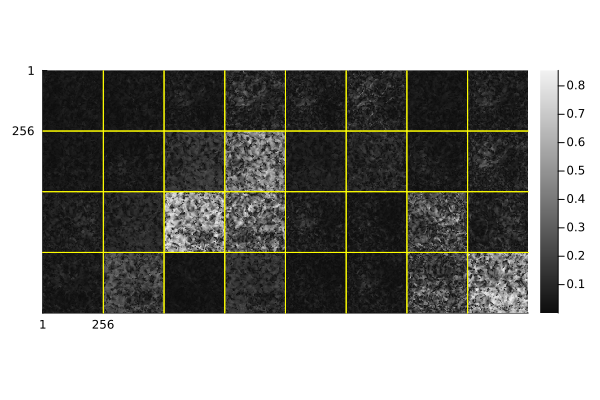

In [76]:
jim(smaps_est)

In [28]:
# ft the filters to the image domain
f_p = zeros(ComplexF64, P, Q, N...);
for i in 1:Λ_len
    f_p[:, :, [Int(N[d]/2) + Λ_idcs[i,d] for d in 1:nd]...] .= reshape(conj.(V0'), P, Λ_len, Q)[:,i,:];
end
h_p = fftshift(ifft(ifftshift(f_p, 3:nd+2), 3:nd+2), 3:nd+2);

In [29]:
# form H(x) matrix
H = reshape(h_p,P,Q,prod(N));

# estimate sensitivity maps
smaps_est = zeros(ComplexF64, Q, prod(N));
ev_est = zeros(ComplexF64, Q, prod(N));
for x in 1:prod(N) # loop through vo/pixels
    # estimate sensitivity at x as last null space vector of G(x)
    (~,σ,V) = svd(H[:,:,x]'*H[:,:,x]);
    smaps_est[:,x] = V[:,1];
    ev_est[:,x] = σ;
    #smaps_est[:,x] = V[:,end];
end
smaps_est = permutedims(reshape(smaps_est, Q, N...),((2:nd+1)...,1));

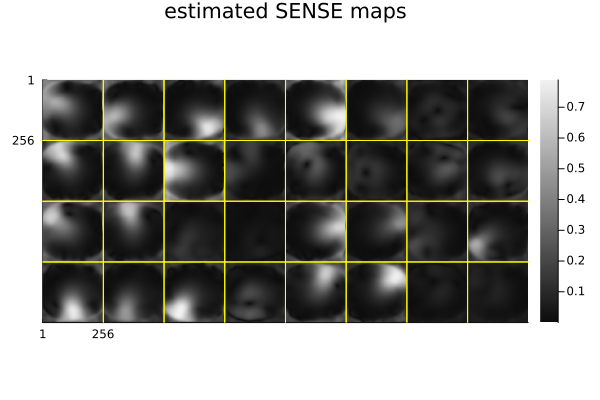

In [30]:
# show the sensitivity maps
jim(smaps_est, title="estimated SENSE maps")

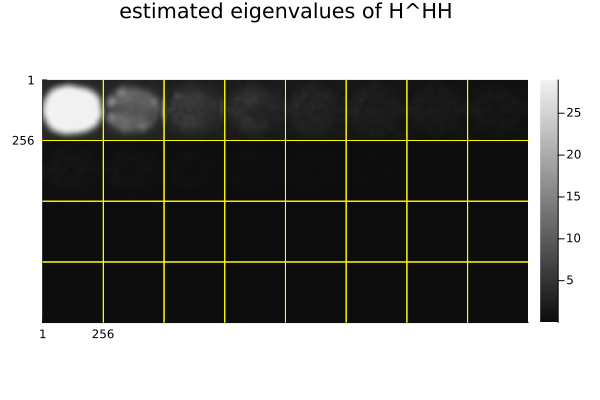

In [31]:
# show the eigenvalues of H'H
jim(prod(N)^nd * reshape(ev_est', N..., Q), title="estimated eigenvalues of H^HH")

To do:
- calculate NPR based on changes:
    - estimate ChC with FFT and see change in NPR